In [1]:
path = r'C:/Users/ruw/Desktop'
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, rf'{path}\RA\penicilin\Libaries')
import bw2data as bd
import bw2calc as bc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
matching_database = "ev391cutoff"
database = "penicillin_cut_off"

In [30]:
import reload_lib as rl
import lca
import standards as s
import sensitivity as st

rl.reload_lib(lca)


In [31]:
from lca import LCA

var = LCA(path=path, matching_database=matching_database, database_name=database)


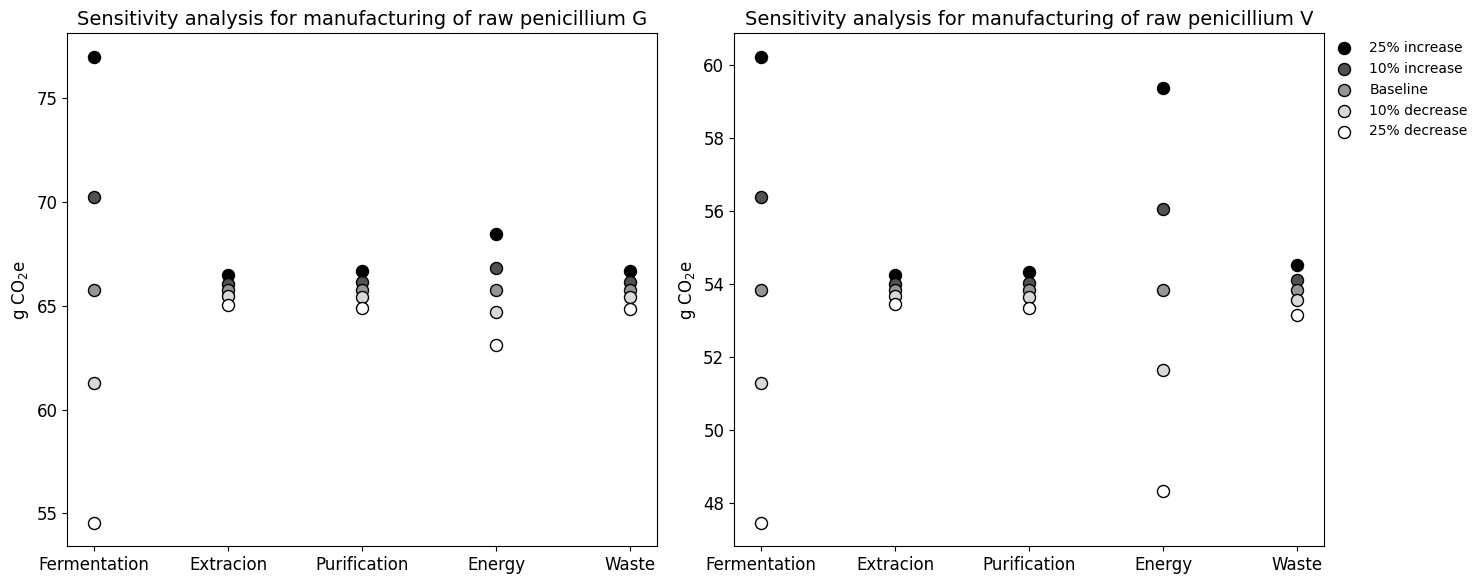

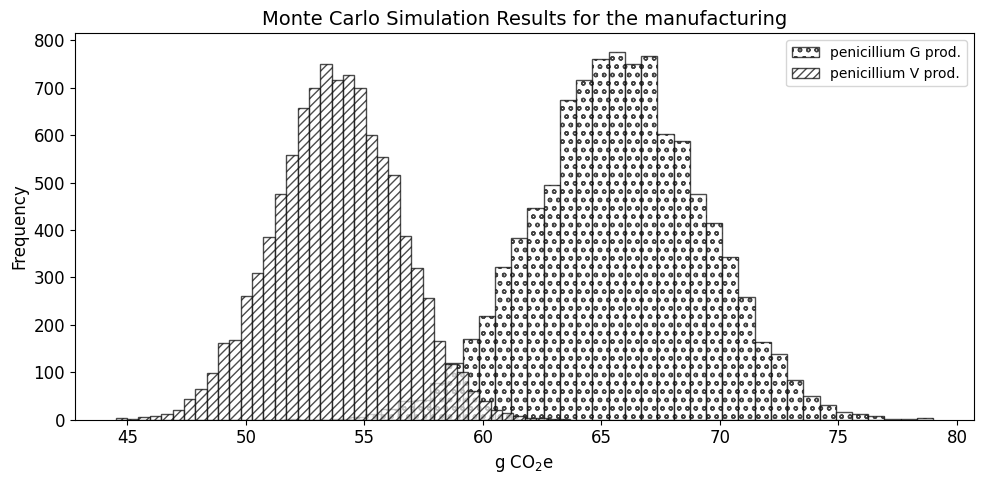

T-value: 271.70777293793077, P-value: 0.0


In [32]:
rl.reload_lib([s, st])
st.perform_sens_uncert_analysis(var.system_path, var.db, mc_base=10, mc_power=4, calc=False)